In [50]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
from scipy import stats
from scipy.stats import norm, skew #for some statistics


In [46]:
train = pd.read_csv('/Users/user/PycharmProjects/Sales-forecast/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/Users/user/PycharmProjects/Sales-forecast/house-prices-advanced-regression-techniques/test.csv')

In [73]:
train.shape

(1456, 81)

In [ ]:
test.shape

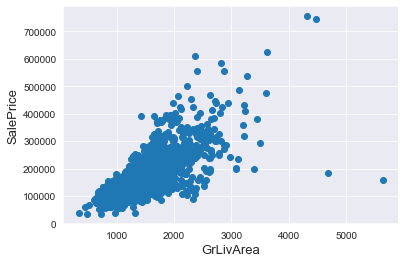

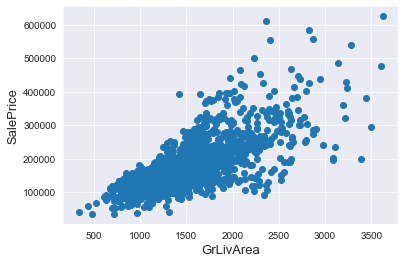

In [48]:
#show outliers
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']>700000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()



 mu = 180151.23 and sigma = 76670.25



Text(0.5, 1.0, 'SalePrice distribution')

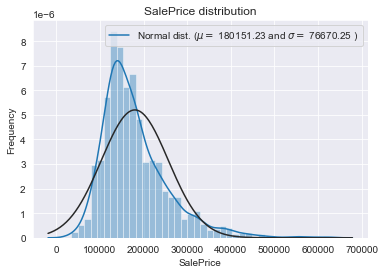

In [52]:
#SalePrice exploration
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')


In [54]:
#features engineering

#concatenate data in the same dataframe
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2915, 80)


In [56]:
#work with missing data
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.725557
MiscFeature,96.397942
Alley,93.207547
Fence,80.445969
FireplaceQu,48.713551
LotFrontage,16.672384
GarageFinish,5.454545
GarageYrBlt,5.454545
GarageQual,5.454545
GarageCond,5.454545


<AxesSubplot:>

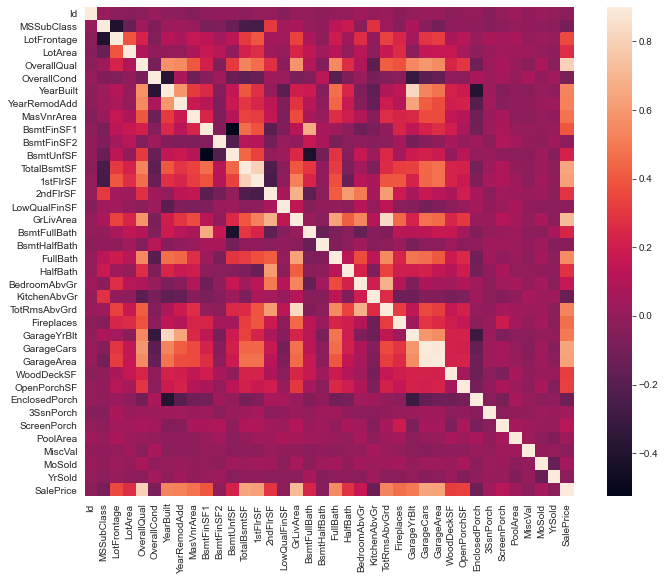

In [57]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [61]:
#fill up missing values


#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

#all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','PoolQC','MiscFeature','Alley','Fence','FireplaceQu'):
    all_data[col] = all_data[col].fillna('None')
    
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

#for Functional NA means typical
all_data["Functional"] = all_data["Functional"].fillna("Typ")

In [62]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio
MasVnrType,0.823328
MasVnrArea,0.789022
MSZoning,0.137221
Utilities,0.068611
SaleType,0.034305


In [63]:
#Transforming some numerical variables that are really categorical
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)


#Since area features are really important we can add one more as a sum
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [74]:
#Getting new train and test set

#rows from train dataset
train = all_data[:ntrain]
#rows since train dataset (test)
test = all_data[ntrain:]
all_data.shape

(2915, 81)

In [76]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
#cross-validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(cross_val_score(model, train.values, y_train, scoring="mean_squared_error", cv = kf))
    return(rmse)

In [ ]:
#define models


In [ ]:
#Score models

In [ ]:
#model eveluation
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [ ]:
#Submission
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)